In [1]:
!pip install tensorflow keras pillow numpy tqdm underthesea gensim fasttext nltk Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 31.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00


In [2]:
import os
import sys
import string
import fasttext
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

from pickle import dump, load
from underthesea import word_tokenize
from gensim.utils import simple_preprocess

from keras.preprocessing.text import Tokenizer
from keras.utils import load_img,img_to_array, plot_model, to_categorical
from keras.preprocessing.sequence import pad_sequences

# from keras.applications.xception import Xception, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, add
from keras.initializers import Constant
from keras.models import Model, load_model

from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu

2024-02-23 09:02:04.072677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 09:02:04.073104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 09:02:04.310235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def convert_to_dict(file_path):
    data_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line in lines:
        line = line.strip()
        if line:
            parts = re.split(r'\t', line)
            image_id = parts[0].split('/')[-1]
            caption = parts[1]

            if image_id not in data_dict:
                data_dict[image_id] = [caption]
            else:
                data_dict[image_id].append(caption)

    return data_dict

def cleaning_text(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, captions in descriptions.items():
        for idx, cap in enumerate(captions):
            desc = cap.replace(' - ', ' ').translate(table)
            desc = ' '.join(simple_preprocess(desc))
            desc = word_tokenize(desc, format='text')
            
            descriptions[img][idx] = 'startseq ' + desc + ' endseq'
    return descriptions

def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(desc.split()) for desc in descriptions[key]]
    
    return vocab

def save_descriptions(descriptions, filename):
    lines = list()
    for key, captions in descriptions.items():
        for cap in captions:
            lines.append(key + '\t' + cap)
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding='utf-8')
    file.write(data)
    file.close()

In [4]:
sample_train_image = '000000157656.jpg'

train_caption_path = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/train/captions.txt'
train_descriptions = convert_to_dict(train_caption_path)

test_caption_path = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/test/captions.txt'
test_descriptions = convert_to_dict(test_caption_path)

train_descriptions[sample_train_image]

['Người đàn ông đang đánh tennis ngoài sân.',
 'Một vận động viên tennis đang vung vợt đánh bóng.',
 'Một cầu thủ tennis đang vung vợt tennis đỡ bóng.',
 'Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng.',
 'Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng.']

In [5]:
clean_train_descriptions = cleaning_text(train_descriptions)
clean_test_descriptions = cleaning_text(test_descriptions)

clean_train_descriptions[sample_train_image]

['startseq người đàn_ông đang đánh tennis ngoài sân endseq',
 'startseq một vận_động_viên tennis đang vung_vợt đánh bóng endseq',
 'startseq một cầu_thủ tennis đang vung vợt tennis đỡ bóng endseq',
 'startseq người đàn_ông đang đứng ngoài biên_cầm vợt sẵn_sàng đỡ bóng endseq',
 'startseq vận_động_viên tennis nam đang trong tư_thế chuẩn_bị đỡ bóng endseq']

In [6]:
save_descriptions(clean_train_descriptions, '/kaggle/working/train_descriptions.txt')
save_descriptions(clean_test_descriptions, '/kaggle/working/test_descriptions.txt')

clean_descriptions = {**clean_train_descriptions, **clean_test_descriptions}
save_descriptions(clean_descriptions, '/kaggle/working/descriptions.txt')

In [7]:
# vocab = text_vocabulary(clean_descriptions)
# print('Length of vocabuary:', len(vocab))

## Extract feature vector from all images

In [8]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input 

def extract_feature(directory):
    model = MobileNetV3Large(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    
    features = dict()
    for img in tqdm(os.listdir(directory), file=sys.stdout):
        filename = directory + '/' + img
        image = load_img(filename, target_size=(224, 224),keep_aspect_ratio=True)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        feature = model.predict(image, verbose=0)
        features[img] = feature
    return features

In [9]:
train_images_path = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/train/images'
test_images_path = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/test/images'

In [10]:
train_features = extract_feature(train_images_path)
dump(train_features, open('/kaggle/working/train_features_mobilenet_V3L.pkl', 'wb'))

22661472/22661472 [==============================] - 1s 0us/step


  0%|          | 0/2695 [00:00<?, ?it/s]

In [11]:
type(train_features)

dict

In [12]:
train_features[sample_train_image]

array([[-2.71446204e+00, -8.15412164e-01, -1.30935729e+00,
        -4.61536884e-01, -3.45781714e-01, -2.20055595e-01,
        -1.94918752e+00,  3.76260430e-01,  1.22586951e-01,
         1.37874752e-01, -1.04828167e+00, -6.11358523e-01,
        -5.79488635e-01,  3.45805883e-01, -7.09476173e-01,
         1.09185576e+00,  2.20207840e-01, -4.87419367e-01,
         5.52247018e-02, -3.91047448e-01,  4.66222346e-01,
         8.98952037e-02,  2.78424859e-01, -7.01740563e-01,
        -1.26007271e+00,  1.06271470e+00,  3.21413517e-01,
        -3.05012733e-01,  5.13201356e-01,  1.06510746e+00,
         1.61719668e+00,  2.24603343e+00,  2.85804129e+00,
        -1.17455840e+00, -1.55418575e+00, -2.83198297e-01,
        -6.61956072e-01, -7.13344514e-01,  1.03279841e+00,
         3.90288413e-01,  5.44254959e-01, -6.42586589e-01,
         2.10048825e-01,  3.64145041e-01,  3.62105697e-01,
        -8.89961064e-01,  4.89995658e-01, -1.01986095e-01,
        -1.05014920e+00,  6.06809556e-01,  3.88456166e-0

In [13]:
test_features = extract_feature(test_images_path)
dump(test_features, open('/kaggle/working/test_features_mobilenet_V3L.pkl', 'wb'))

  0%|          | 0/231 [00:00<?, ?it/s]

In [14]:
train_imgs = list(clean_train_descriptions)
train_descriptions = clean_train_descriptions
train_features = train_features

In [15]:
test_imgs = list(clean_test_descriptions)
test_descriptions = clean_test_descriptions
test_features = test_features

## Tokenizing the vocabulary and word embedding

In [16]:
def dict_to_list(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    oov_token = 'unk'
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

def create_embedding_matrix(vocab):
    embedding_index = fasttext.load_model('/kaggle/input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')
    
    embedding_dim = 300
    hits = 0
    misses = 0
    vocab_size = len(vocab) + 1
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    return embedding_matrix

In [17]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('# vocabulary:', vocab_size)

# vocabulary: 1151


In [18]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(desc.split()) for desc in desc_list)

max_length = max_length(train_descriptions)
print('Max length of train set:', max_length)

Max length of train set: 32


In [19]:
vocab = tokenizer.word_index
embedding_matrix = create_embedding_matrix(vocab)
print(embedding_matrix.shape)

Converted 1150 words (0 misses)
(1151, 300)


## Data generator

In [20]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key, captions in descriptions.items():
            n += 1
            feature = features[key][0]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [22]:
[a, b], c = next(data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, 32))
a.shape, b.shape, c.shape

((2204, 1000), (2204, 32), (2204, 1151))

## CNN-RNN model

In [23]:
def define_model(vocab_size, max_length):
    embedding_dim = 300
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        mask_zero=True,
        trainable=False,
    )(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Bidirectional(LSTM(128))(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [24]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 50
batch_size = 32
steps = len(train_imgs) // batch_size

Dataset:  2695
Descriptions: train= 2695
Photos: train= 2695
Vocabulary Size: 1151
Description Length:  32
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 300)              345300    ['input_4[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 1000)                 0         ['input_3[0][0]'

In [25]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save("/kaggle/working/best_model.h5")

84/84 [==============================] - 164s 2s/step - loss: 1.3871


## Evaluate

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([image, seq], verbose=0)
        pred_ids = np.argmax(yhat)
        word = idx_to_word(pred_ids, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name, dataset_images_path, descriptions, features):
    image_path = os.path.join(dataset_images_path, image_name)
    image = Image.open(image_path)
#     descriptions = load_descriptions('./descriptions.txt', train_imgs + test_imgs)
    captions = descriptions[image_name]
    print('-' * 20 + 'Actual' + '-' * 20)
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('-' * 20 + 'Predicted' + '-' * 20)
    print(y_pred)
    plt.imshow(image)

--------------------Actual--------------------
startseq các cầu_thủ bóng chày đang thi_đấu trong sân_vận_động với đông_đảo khản giả endseq
startseq một_số người đang chơi bóng_chày trên sân dưới trời nắng endseq
startseq khán_giả đang xem trận đấu bóng chày đang được diễn ra endseq
startseq hình_ảnh của một trận đấu bóng chày đang được diễn ra endseq
startseq các cầu_thủ bóng chày đang thi_đấu trên sân với đám đông đang quan_sát endseq
--------------------Predicted--------------------
startseq các cầu thủ bóng chày đang thi đấu trên sân endseq


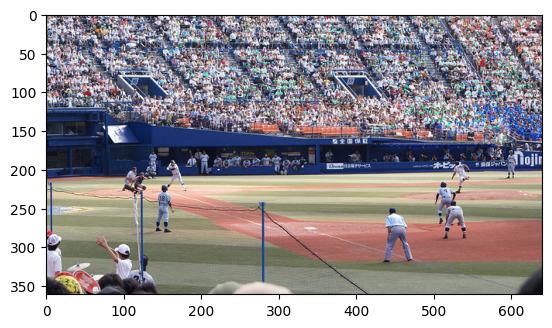

In [36]:
from random import sample

image_name = sample(train_imgs, 1)[0]
generate_caption(image_name, train_images_path, train_descriptions, train_features)

--------------------Actual--------------------
startseq những người đàn_ông đang luyện_tập bóng chày trong khung lưới endseq
startseq cậu bé đang vung_gậy để đánh_quả bóng chày trước tấm lưới endseq
startseq cậu bé đang vung_gậy để đánh_quả bóng_chày trên sân endseq
startseq những người đàn_ông đang chơi bóng_chày trong khung lưới endseq
startseq một cầu_thủ bóng chày đang dùng gậy để đánh bóng trước tâm lưới endseq
--------------------Predicted--------------------
startseq một cậu bé đang xoay người để đánh quả bóng chày endseq


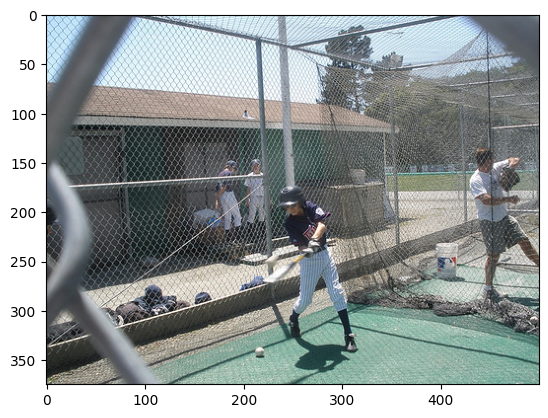

In [37]:
image_name = sample(test_imgs, 1)[0]
generate_caption(image_name, test_images_path, test_descriptions, test_features)